# Mini Project: Dermatologist AI

#### Udacity, Deep Learning Nanodegree, Unit 3
##### Jose Quinonez, Oct 29 2019

The data and objective are pulled from the 2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection. As part of the challenge, participants were tasked to design an algorithm to diagnose skin lesion images as one of three different skin diseases: melanoma, nevus, or seborrheic keratosis.<br>
    
Melanoma is a malignant skin tumor, while nevus and seborrheic keratosis are two types of benign lesions
The exercise designs an algorithm to correctly classify these skin lessions through the use of Transfer Learning (vgg16 in this case).

There are two types of classification modes:<br>
1- Complete classification of the three classes (0=melanoma, 1=nevus, 2=seborrheic keratosis) <br>
2- Malignant vs Bening (0=melanoma, 1=nevus or seborrheic keratosis)

ISIC provides a training, evaluation and testing datasets with the three types of skin lessions. <br>
The goal is to achieve the highest accuracy predicting on the test dataset.

Hyperparameters for fine-tunning are: number of epochs, batch size, learning rate, optimizer. Other strategy is to use cyclical learning rates during training iterations. <br>

The architecture of the layer(s) that complete VGG16 is also a subject for further optimization. <br>

The classification mode could also be a factor for improving accuracy and response time. it is expected that the Malignant vs Bening mode gets better accuracy than the Complete classification due to the fewer number of classes.

The datasets are located here:
- https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
- https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
- https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip

Requirements to reproduce this notebook:
- Create a folder named 'data', create subfolders 'train', 'valid', and 'test' under 'data'
- Download data files
- Install numpy, glob, cv2, matplotlib, os, torch, torchvision, PIL
- Copy sampler.py in the same directory of this notebook

### Data preparation

In [1]:
# Load libraries
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt
import os

from sampler import ImbalancedDatasetSampler
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix

In [2]:
# Load filenames for train images folder
train_melanoma = np.array(glob("data/train/melanoma/*"))
train_nevus = np.array(glob("data/train/nevus/*"))
train_sk = np.array(glob("data/train/seborrheic_keratosis/*"))

# Print number of images in each dataset
print('There are %d total melanoma train images.' % len(train_melanoma))
print('There are %d total nevus train images.' % len(train_nevus))
print('There are %d total seborrheic keratosis train images.' % \
      len(train_sk))
print('There are %d total train images.' % \
      (len(train_melanoma)+len(train_nevus)+len(train_sk)))


There are 374 total melanoma train images.
There are 1372 total nevus train images.
There are 254 total seborrheic keratosis train images.
There are 2000 total train images.


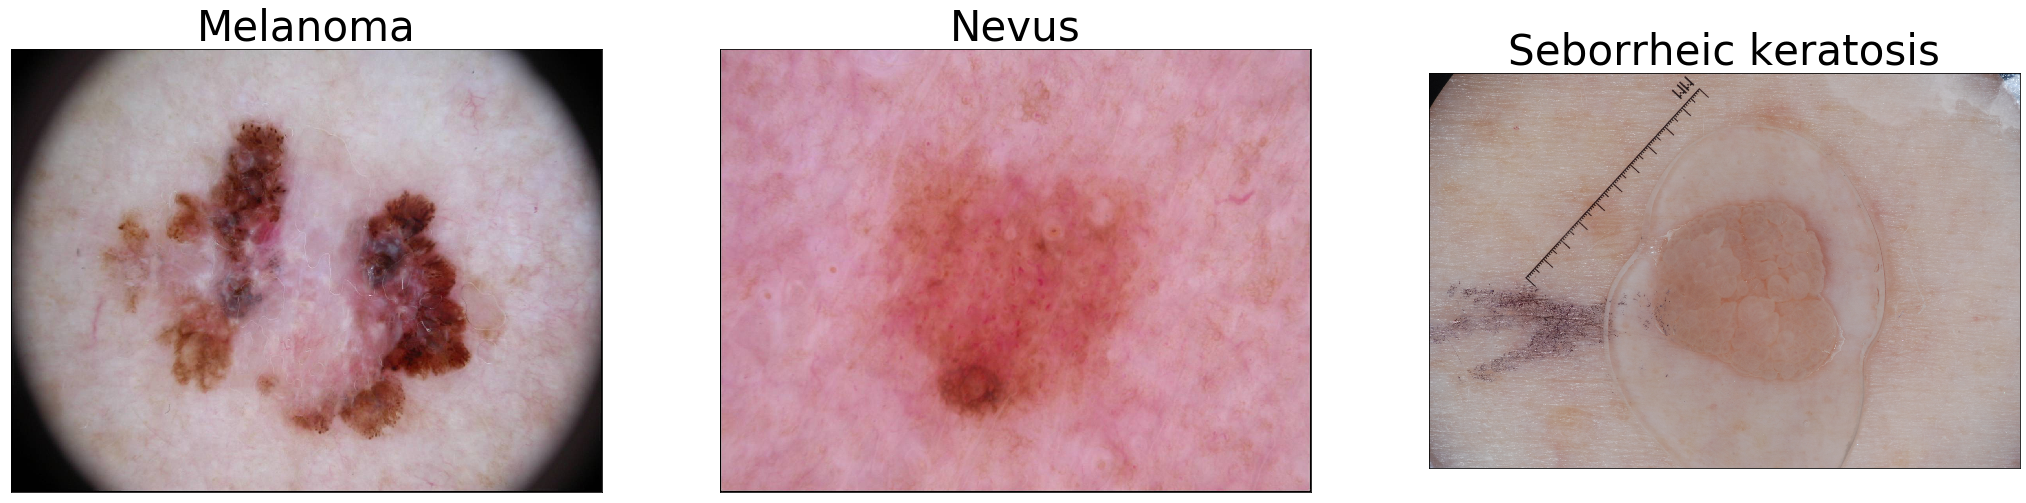

In [3]:
%matplotlib inline 

# Plot a sample image from each dataset
img_melanoma = cv2.imread(train_melanoma[0])
img_nevus = cv2.imread(train_nevus[0])
img_sk = cv2.imread(train_sk[0])
images = {'Melanoma':img_melanoma, 'Nevus':img_nevus, 'Seborrheic keratosis':img_sk }

fig = plt.figure(figsize = (36, 10)) 
for idx, image in enumerate(images):
    cv_rgb = cv2.cvtColor(images[image], cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(1, 3, idx + 1, xticks=[], yticks=[])
    ax.set_title(image, size=42)
    ax.imshow(cv_rgb)


In [4]:
# Release memory
train_melanoma, train_nevus, train_sk = None, None, None

In [5]:
# Set data directories
data_dir = 'data/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

In [6]:
# Load data tensors using ImbalancedDatasetSampler to balance datasets
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)

print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))
print('Num validation images: ', len(valid_data))

num_workers = 0
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers,
                                          sampler = ImbalancedDatasetSampler(train_data))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers,
                                          sampler=ImbalancedDatasetSampler(test_data))
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers,
                                           sampler=ImbalancedDatasetSampler(valid_data))

loaders_transfer = {}
loaders_transfer['train'] = train_loader
loaders_transfer['test'] = test_loader
loaders_transfer['valid'] = valid_loader

Num training images:  2000
Num test images:  600
Num validation images:  150


### Define functions to create, train and test the model

In [7]:
# Create transfer learning model

# Check if CUDA is available
use_cuda = torch.cuda.is_available()

def create_model(num_classes, TL_case=1):  
    # Define transfer learning model based on VGG16
    model = models.vgg16(pretrained=True)

    # If case <> 4: use pre-trained weights in the nn
    if (TL_case != 4):
        # Freeze training for all "features" layers
        for param in model.features.parameters():
            param.requires_grad = False

    # if case <> 2: use all nn until last classifier layer 
    if (TL_case != 2):
        # identify the number of inputs according to the nn's layer
        n_inputs = model.classifier[6].in_features
        # add one hidden layer before output layer
        depth = int(np.sqrt(n_inputs*num_classes))
        last_layer = nn.Sequential(nn.Linear(n_inputs, num_classes))
        model.classifier[6] = last_layer
    
    # if case = 2: use only the first conv layer (takes longer time)
    else:
        n_inputs = 64*112*112 # output from nn' feature 4          
        depth = int(np.sqrt(n_inputs*num_classes)) 
        last_layer = nn.Sequential(nn.Dropout(0.5),
                                   nn.Linear(n_inputs, depth), 
                                   nn.ReLU(True),
                                   nn.Dropout(0.5),
                                   nn.Linear(depth, num_classes))

        class vgg16Conv2(nn.Module):
                    def __init__(self):
                        super(vgg16Conv2, self).__init__()
                        self.features = nn.Sequential(
                            # stop at feature 5
                            *list(model.features.children())[:5], 
                            nn.AdaptiveAvgPool2d(output_size=(112, 112)),
                        ) 
                        self.classifier = last_layer

                    def forward(self, x):
                        x = self.features(x)
                        x = x.view(-1, 64 * 112 * 112)
                        x = self.classifier(x)
                        return x

        model = vgg16Conv2()

    # Use normalized weights instead of default randomized
    for m in model.classifier[6]:
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            # Get the number of the inputs
            n = m.in_features
            y = (1.0/np.sqrt(n))
            m.weight.data.normal_(0, y)
            m.bias.data.fill_(0)
        
    if use_cuda:
        model = model.cuda()
    
    return model

In [8]:
def train_iteration(model, train_data, train_target, optimizer, criterion, mode):
    # Forward and backward passes
    
    model.train()
    
    # If malignant vs bening change labels for train and valid datasets
    if mode==2:
        target_np = train_target.cpu().numpy()
        target_np = (target_np != np.zeros(len(target_np))).astype(int)
        train_target = torch.from_numpy(target_np)

    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output, train_target)
    loss.backward()
    optimizer.step()
            
    # Return trained model
    return model

In [9]:
 def get_validation_acc(model, loaders, optimizer, criterion, mode):
    # Calculate accuracy on the validation dataset
    
    correct = 0.
    total = 0.
    print("\nCalculating accuracy for the validation dataset")

    model.eval()

    for batch_idx, (valid_data, valid_target) in enumerate(loaders['valid']):
        # Move to GPU
        if use_cuda:
            valid_data, valid_target = valid_data.cuda(), valid_target.cuda()
                
        # If malignant vs bening then change labels
        if mode==2:
            target_np = valid_target.cpu().numpy()
            target_np = (target_np != np.zeros(len(target_np))).astype(int)
            valid_target = torch.from_numpy(target_np) 
                
        # Update the average validation accuracy         
        output = model(valid_data)
        pred = output.data.max(1, keepdim=True)[1]
        # Compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(valid_target.data.view_as(pred))).cpu().numpy())
        total += valid_data.size(0)
    
    acc = 100. * correct / total
    print('Iteration Accuracy: %2d%% (%2d/%2d)' % (
        acc, correct, total))            
    # Return accuracy
    return acc

In [10]:
def test(loaders, model, criterion, use_cuda, mode):

    # Monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    total_target = []
    total_pred = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # Move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # If malignant vs bening then change labels
        if mode==2:
            target_np = target.cpu().numpy()
            target_np = (target_np != np.zeros(len(target_np))).astype(int)
            target = torch.from_numpy(target_np) 
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output, target)
        # Update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # Convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # Compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
        # Acum list of predictions and targets for confussion matrix
        target_np = target.squeeze().numpy()
        pred_np = pred.squeeze().numpy()
        total_target = np.concatenate((total_target, target_np))
        total_pred = np.concatenate((total_pred, pred_np))
                

            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    return(total_target, total_pred)

In [11]:
# Source: http://teleported.in/posts/cyclic-learning-rate/
def get_triangular_lr(iteration, stepsize, base_lr, max_lr):
    """Given the inputs, calculates the lr that should be applicable for this iteration"""
    cycle = np.floor(1 + iteration/(2  * stepsize))
    x = np.abs(iteration/stepsize - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
    return lr

### Create/Load the model

In [12]:
# Create the transfer learming model

# Initial configuration
mode = 1 # Complete classification
base_lr = 0.0001
max_lr = 0.006

# Determine number of classes according to the type of classification
if mode == 1: # Complete classification
    num_classes = 3
else: # Malignant vs Bening
    num_classes = 2

"""
    Transfer Learning cases according to data:
    
    Case 1: Small Data Set, Similar Data
    - Use all neural network holding pre-trained weights.
    - At the end of nn, add a fc layer adjusted to the number of classes. Use random weights in this layer.

    Case 2: Small Data Set, Different Data
    - Use just the initial layers of neural network holding pre-trained weights to avoid overfitting.
    - At the initial layers of nn, Add an fc layer adjusted to the number of classes. Use random weights in this layer.

    Case 3: Large Data Set, Similar Data
    - Use all neural network holding pre-trained weights.
    - At the end of nn, Add an fc layer adjusted to the number of classes. Use random weights in this layer.

    Case 4: Large Data Set, Different Data
    - Use all neural network, but use random weights (not pre-trained weights)
    - At the end of nn, Add an fc layer adjusted to the number of classes. Use random weights in this layer.

The skin lession images are different and smaller than the source model.
So it would apply a case 2 of transfer learning, but this would require 
to retrain the model almost from the initial layers, which would take 
a lot of computing resources.

Then I am using transfer learning case = 1 to move on
"""

TL_case = 1 # small and "similar" dataset

# Create model
model_transfer = create_model(num_classes, TL_case)
lr = base_lr
#optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=lr, momentum=0.9, nesterov=True)
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=lr)

# Load previously trained model if available
save_path = 'model_transfer.pt'
try:
    print ("Loading saved model")
    checkpoint = torch.load(save_path)
    model_transfer.load_state_dict(checkpoint['state_dict'])
    optimizer_transfer.load_state_dict(checkpoint['optimizer'])
    list_iteration = checkpoint['list_iteration']
    last_iteration = list_iteration[-1] + 1
    list_acc = checkpoint['list_acc']
except:
    print ("No previously saved model. Create from scratch")
    list_iteration = []
    last_iteration = 1
    list_acc = []

criterion_transfer = nn.CrossEntropyLoss() 

Loading saved model


* The last saved model could be used to refine the training or to test the model's accuracy.

### Model training using cyclical learning rates

In [13]:
# Training using Cyclical learning rate
# "Cyclical Learning Rates for Training Neural Networks", Leslie N. Smith
# https://arxiv.org/pdf/1506.01186.pdf

# Cycle configuration
num_iterations_per_epoch = len(loaders_transfer['train'])
num_epochs_per_stepsize = 8
num_iterations_per_stepsize = num_iterations_per_epoch*num_epochs_per_stepsize
num_iterations_per_cycle = num_iterations_per_stepsize*2
num_cycles = 3
num_iterations_total = int(num_iterations_per_cycle*num_cycles)
n_iterations = 1000

print("Number of iterations to train:", num_iterations_total)
print("Save model every", n_iterations, "iterations")

Number of iterations to train: 6000
Save model every 1000 iterations


In [14]:
# Cyclical learning rate training

# Prepare training loader
train_dataloader_iterator = iter(loaders_transfer["train"])

# Training iterations 
for iteration in range(last_iteration, last_iteration+num_iterations_total):
    print("Iteration ", iteration)
    # Calculate learning rate to be used
    lr = get_triangular_lr(iteration, num_iterations_per_stepsize, base_lr, max_lr)
    # Use learning rate in optimizer
    #optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=lr, momentum=0.9, nesterov=True)
    optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=lr)
    # Get next batch of training data
    try:
        train_data, train_target = next(train_dataloader_iterator)
    except StopIteration:
        train_dataloader_iterator = iter(loaders_transfer["train"])
        train_data, train_target = next(train_dataloader_iterator)
    # Use cuda if available
    if use_cuda:
        train_data, train_target = train_data.cuda(), train_target.cuda()
    # Train batch of data
    model_transfer = train_iteration(model_transfer, train_data, train_target, optimizer_transfer, criterion_transfer, mode)    
    
    # save model every 1000 n_iterations or end of loop
    if ((iteration % n_iterations) == 0) | (iteration == last_iteration+num_iterations_total-1):
        
        # Calculate accuracy on the validation dataset at the end of training loop
        acc = get_validation_acc(model_transfer, loaders_transfer, optimizer_transfer, criterion_transfer, mode)  
        
        list_iteration.append(iteration)
        list_acc.append(acc)

        # Save trained model checkpoint
        checkpoint = {
                    'list_iteration': list_iteration,
                    'state_dict': model_transfer.state_dict(),
                    'optimizer': optimizer_transfer.state_dict(),
                    'list_acc':list_acc
                    }
        torch.save(checkpoint, save_path)


Iteration  6001
Iteration  6002
Iteration  6003
Iteration  6004
Iteration  6005
Iteration  6006
Iteration  6007
Iteration  6008
Iteration  6009
Iteration  6010
Iteration  6011
Iteration  6012
Iteration  6013
Iteration  6014
Iteration  6015
Iteration  6016
Iteration  6017
Iteration  6018
Iteration  6019
Iteration  6020
Iteration  6021
Iteration  6022
Iteration  6023
Iteration  6024
Iteration  6025
Iteration  6026
Iteration  6027
Iteration  6028
Iteration  6029
Iteration  6030
Iteration  6031
Iteration  6032
Iteration  6033
Iteration  6034
Iteration  6035
Iteration  6036
Iteration  6037
Iteration  6038
Iteration  6039
Iteration  6040
Iteration  6041
Iteration  6042
Iteration  6043
Iteration  6044
Iteration  6045
Iteration  6046
Iteration  6047
Iteration  6048
Iteration  6049
Iteration  6050
Iteration  6051
Iteration  6052
Iteration  6053
Iteration  6054
Iteration  6055
Iteration  6056
Iteration  6057
Iteration  6058
Iteration  6059
Iteration  6060
Iteration  6061
Iteration  6062
Iteratio

Iteration  6514
Iteration  6515
Iteration  6516
Iteration  6517
Iteration  6518
Iteration  6519
Iteration  6520
Iteration  6521
Iteration  6522
Iteration  6523
Iteration  6524
Iteration  6525
Iteration  6526
Iteration  6527
Iteration  6528
Iteration  6529
Iteration  6530
Iteration  6531
Iteration  6532
Iteration  6533
Iteration  6534
Iteration  6535
Iteration  6536
Iteration  6537
Iteration  6538
Iteration  6539
Iteration  6540
Iteration  6541
Iteration  6542
Iteration  6543
Iteration  6544
Iteration  6545
Iteration  6546
Iteration  6547
Iteration  6548
Iteration  6549
Iteration  6550
Iteration  6551
Iteration  6552
Iteration  6553
Iteration  6554
Iteration  6555
Iteration  6556
Iteration  6557
Iteration  6558
Iteration  6559
Iteration  6560
Iteration  6561
Iteration  6562
Iteration  6563
Iteration  6564
Iteration  6565
Iteration  6566
Iteration  6567
Iteration  6568
Iteration  6569
Iteration  6570
Iteration  6571
Iteration  6572
Iteration  6573
Iteration  6574
Iteration  6575
Iteratio

Iteration  7021
Iteration  7022
Iteration  7023
Iteration  7024
Iteration  7025
Iteration  7026
Iteration  7027
Iteration  7028
Iteration  7029
Iteration  7030
Iteration  7031
Iteration  7032
Iteration  7033
Iteration  7034
Iteration  7035
Iteration  7036
Iteration  7037
Iteration  7038
Iteration  7039
Iteration  7040
Iteration  7041
Iteration  7042
Iteration  7043
Iteration  7044
Iteration  7045
Iteration  7046
Iteration  7047
Iteration  7048
Iteration  7049
Iteration  7050
Iteration  7051
Iteration  7052
Iteration  7053
Iteration  7054
Iteration  7055
Iteration  7056
Iteration  7057
Iteration  7058
Iteration  7059
Iteration  7060
Iteration  7061
Iteration  7062
Iteration  7063
Iteration  7064
Iteration  7065
Iteration  7066
Iteration  7067
Iteration  7068
Iteration  7069
Iteration  7070
Iteration  7071
Iteration  7072
Iteration  7073
Iteration  7074
Iteration  7075
Iteration  7076
Iteration  7077
Iteration  7078
Iteration  7079
Iteration  7080
Iteration  7081
Iteration  7082
Iteratio

Iteration  7534
Iteration  7535
Iteration  7536
Iteration  7537
Iteration  7538
Iteration  7539
Iteration  7540
Iteration  7541
Iteration  7542
Iteration  7543
Iteration  7544
Iteration  7545
Iteration  7546
Iteration  7547
Iteration  7548
Iteration  7549
Iteration  7550
Iteration  7551
Iteration  7552
Iteration  7553
Iteration  7554
Iteration  7555
Iteration  7556
Iteration  7557
Iteration  7558
Iteration  7559
Iteration  7560
Iteration  7561
Iteration  7562
Iteration  7563
Iteration  7564
Iteration  7565
Iteration  7566
Iteration  7567
Iteration  7568
Iteration  7569
Iteration  7570
Iteration  7571
Iteration  7572
Iteration  7573
Iteration  7574
Iteration  7575
Iteration  7576
Iteration  7577
Iteration  7578
Iteration  7579
Iteration  7580
Iteration  7581
Iteration  7582
Iteration  7583
Iteration  7584
Iteration  7585
Iteration  7586
Iteration  7587
Iteration  7588
Iteration  7589
Iteration  7590
Iteration  7591
Iteration  7592
Iteration  7593
Iteration  7594
Iteration  7595
Iteratio

Iteration  8041
Iteration  8042
Iteration  8043
Iteration  8044
Iteration  8045
Iteration  8046
Iteration  8047
Iteration  8048
Iteration  8049
Iteration  8050
Iteration  8051
Iteration  8052
Iteration  8053
Iteration  8054
Iteration  8055
Iteration  8056
Iteration  8057
Iteration  8058
Iteration  8059
Iteration  8060
Iteration  8061
Iteration  8062
Iteration  8063
Iteration  8064
Iteration  8065
Iteration  8066
Iteration  8067
Iteration  8068
Iteration  8069
Iteration  8070
Iteration  8071
Iteration  8072
Iteration  8073
Iteration  8074
Iteration  8075
Iteration  8076
Iteration  8077
Iteration  8078
Iteration  8079
Iteration  8080
Iteration  8081
Iteration  8082
Iteration  8083
Iteration  8084
Iteration  8085
Iteration  8086
Iteration  8087
Iteration  8088
Iteration  8089
Iteration  8090
Iteration  8091
Iteration  8092
Iteration  8093
Iteration  8094
Iteration  8095
Iteration  8096
Iteration  8097
Iteration  8098
Iteration  8099
Iteration  8100
Iteration  8101
Iteration  8102
Iteratio

Iteration  8554
Iteration  8555
Iteration  8556
Iteration  8557
Iteration  8558
Iteration  8559
Iteration  8560
Iteration  8561
Iteration  8562
Iteration  8563
Iteration  8564
Iteration  8565
Iteration  8566
Iteration  8567
Iteration  8568
Iteration  8569
Iteration  8570
Iteration  8571
Iteration  8572
Iteration  8573
Iteration  8574
Iteration  8575
Iteration  8576
Iteration  8577
Iteration  8578
Iteration  8579
Iteration  8580
Iteration  8581
Iteration  8582
Iteration  8583
Iteration  8584
Iteration  8585
Iteration  8586
Iteration  8587
Iteration  8588
Iteration  8589
Iteration  8590
Iteration  8591
Iteration  8592
Iteration  8593
Iteration  8594
Iteration  8595
Iteration  8596
Iteration  8597
Iteration  8598
Iteration  8599
Iteration  8600
Iteration  8601
Iteration  8602
Iteration  8603
Iteration  8604
Iteration  8605
Iteration  8606
Iteration  8607
Iteration  8608
Iteration  8609
Iteration  8610
Iteration  8611
Iteration  8612
Iteration  8613
Iteration  8614
Iteration  8615
Iteratio

Iteration  9061
Iteration  9062
Iteration  9063
Iteration  9064
Iteration  9065
Iteration  9066
Iteration  9067
Iteration  9068
Iteration  9069
Iteration  9070
Iteration  9071
Iteration  9072
Iteration  9073
Iteration  9074
Iteration  9075
Iteration  9076
Iteration  9077
Iteration  9078
Iteration  9079
Iteration  9080
Iteration  9081
Iteration  9082
Iteration  9083
Iteration  9084
Iteration  9085
Iteration  9086
Iteration  9087
Iteration  9088
Iteration  9089
Iteration  9090
Iteration  9091
Iteration  9092
Iteration  9093
Iteration  9094
Iteration  9095
Iteration  9096
Iteration  9097
Iteration  9098
Iteration  9099
Iteration  9100
Iteration  9101
Iteration  9102
Iteration  9103
Iteration  9104
Iteration  9105
Iteration  9106
Iteration  9107
Iteration  9108
Iteration  9109
Iteration  9110
Iteration  9111
Iteration  9112
Iteration  9113
Iteration  9114
Iteration  9115
Iteration  9116
Iteration  9117
Iteration  9118
Iteration  9119
Iteration  9120
Iteration  9121
Iteration  9122
Iteratio

Iteration  9574
Iteration  9575
Iteration  9576
Iteration  9577
Iteration  9578
Iteration  9579
Iteration  9580
Iteration  9581
Iteration  9582
Iteration  9583
Iteration  9584
Iteration  9585
Iteration  9586
Iteration  9587
Iteration  9588
Iteration  9589
Iteration  9590
Iteration  9591
Iteration  9592
Iteration  9593
Iteration  9594
Iteration  9595
Iteration  9596
Iteration  9597
Iteration  9598
Iteration  9599
Iteration  9600
Iteration  9601
Iteration  9602
Iteration  9603
Iteration  9604
Iteration  9605
Iteration  9606
Iteration  9607
Iteration  9608
Iteration  9609
Iteration  9610
Iteration  9611
Iteration  9612
Iteration  9613
Iteration  9614
Iteration  9615
Iteration  9616
Iteration  9617
Iteration  9618
Iteration  9619
Iteration  9620
Iteration  9621
Iteration  9622
Iteration  9623
Iteration  9624
Iteration  9625
Iteration  9626
Iteration  9627
Iteration  9628
Iteration  9629
Iteration  9630
Iteration  9631
Iteration  9632
Iteration  9633
Iteration  9634
Iteration  9635
Iteratio

Iteration  10077
Iteration  10078
Iteration  10079
Iteration  10080
Iteration  10081
Iteration  10082
Iteration  10083
Iteration  10084
Iteration  10085
Iteration  10086
Iteration  10087
Iteration  10088
Iteration  10089
Iteration  10090
Iteration  10091
Iteration  10092
Iteration  10093
Iteration  10094
Iteration  10095
Iteration  10096
Iteration  10097
Iteration  10098
Iteration  10099
Iteration  10100
Iteration  10101
Iteration  10102
Iteration  10103
Iteration  10104
Iteration  10105
Iteration  10106
Iteration  10107
Iteration  10108
Iteration  10109
Iteration  10110
Iteration  10111
Iteration  10112
Iteration  10113
Iteration  10114
Iteration  10115
Iteration  10116
Iteration  10117
Iteration  10118
Iteration  10119
Iteration  10120
Iteration  10121
Iteration  10122
Iteration  10123
Iteration  10124
Iteration  10125
Iteration  10126
Iteration  10127
Iteration  10128
Iteration  10129
Iteration  10130
Iteration  10131
Iteration  10132
Iteration  10133
Iteration  10134
Iteration  101

Iteration  10559
Iteration  10560
Iteration  10561
Iteration  10562
Iteration  10563
Iteration  10564
Iteration  10565
Iteration  10566
Iteration  10567
Iteration  10568
Iteration  10569
Iteration  10570
Iteration  10571
Iteration  10572
Iteration  10573
Iteration  10574
Iteration  10575
Iteration  10576
Iteration  10577
Iteration  10578
Iteration  10579
Iteration  10580
Iteration  10581
Iteration  10582
Iteration  10583
Iteration  10584
Iteration  10585
Iteration  10586
Iteration  10587
Iteration  10588
Iteration  10589
Iteration  10590
Iteration  10591
Iteration  10592
Iteration  10593
Iteration  10594
Iteration  10595
Iteration  10596
Iteration  10597
Iteration  10598
Iteration  10599
Iteration  10600
Iteration  10601
Iteration  10602
Iteration  10603
Iteration  10604
Iteration  10605
Iteration  10606
Iteration  10607
Iteration  10608
Iteration  10609
Iteration  10610
Iteration  10611
Iteration  10612
Iteration  10613
Iteration  10614
Iteration  10615
Iteration  10616
Iteration  106

Iteration  11037
Iteration  11038
Iteration  11039
Iteration  11040
Iteration  11041
Iteration  11042
Iteration  11043
Iteration  11044
Iteration  11045
Iteration  11046
Iteration  11047
Iteration  11048
Iteration  11049
Iteration  11050
Iteration  11051
Iteration  11052
Iteration  11053
Iteration  11054
Iteration  11055
Iteration  11056
Iteration  11057
Iteration  11058
Iteration  11059
Iteration  11060
Iteration  11061
Iteration  11062
Iteration  11063
Iteration  11064
Iteration  11065
Iteration  11066
Iteration  11067
Iteration  11068
Iteration  11069
Iteration  11070
Iteration  11071
Iteration  11072
Iteration  11073
Iteration  11074
Iteration  11075
Iteration  11076
Iteration  11077
Iteration  11078
Iteration  11079
Iteration  11080
Iteration  11081
Iteration  11082
Iteration  11083
Iteration  11084
Iteration  11085
Iteration  11086
Iteration  11087
Iteration  11088
Iteration  11089
Iteration  11090
Iteration  11091
Iteration  11092
Iteration  11093
Iteration  11094
Iteration  110

Iteration  11519
Iteration  11520
Iteration  11521
Iteration  11522
Iteration  11523
Iteration  11524
Iteration  11525
Iteration  11526
Iteration  11527
Iteration  11528
Iteration  11529
Iteration  11530
Iteration  11531
Iteration  11532
Iteration  11533
Iteration  11534
Iteration  11535
Iteration  11536
Iteration  11537
Iteration  11538
Iteration  11539
Iteration  11540
Iteration  11541
Iteration  11542
Iteration  11543
Iteration  11544
Iteration  11545
Iteration  11546
Iteration  11547
Iteration  11548
Iteration  11549
Iteration  11550
Iteration  11551
Iteration  11552
Iteration  11553
Iteration  11554
Iteration  11555
Iteration  11556
Iteration  11557
Iteration  11558
Iteration  11559
Iteration  11560
Iteration  11561
Iteration  11562
Iteration  11563
Iteration  11564
Iteration  11565
Iteration  11566
Iteration  11567
Iteration  11568
Iteration  11569
Iteration  11570
Iteration  11571
Iteration  11572
Iteration  11573
Iteration  11574
Iteration  11575
Iteration  11576
Iteration  115


Calculating accuracy for the validation dataset
Iteration Accuracy: 60% (91/150)


### Test model's accuracy

In [15]:
# Get loss and accuracy using the saved model on the test dataset
y_true, y_pred = test(loaders_transfer, model_transfer, criterion_transfer, use_cuda, mode)

Test Loss: 0.902470


Test Accuracy: 61% (371/600)


In [16]:
# Show confusion matrix
print("Confussion matrix")
confusion_matrix(y_true, y_pred)

Confussion matrix


array([[108,  18,  66],
       [ 45,  81,  69],
       [ 13,  18, 182]])

* In a balanced dataset errors should be randomly distributed,
while in an imbalanced dataset predictions are biased to the heavy classes (columns in the confusion matrix)